In [40]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import nltk
from nltk.corpus import stopwords

In [42]:
#Importar datos
df = pd.read_csv("../data/cleaned_comments.csv")

# Parsear como UTC
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# Convertir a zona local
df['published_at'] = df['published_at'].dt.tz_convert('America/Bogota')

# Establecer el índice temporal ordenado
df = df.set_index('published_at').sort_index()

print(df.head())  # Verificar el DataFrame

                              video_id                  comment_id  \
published_at                                                         
2025-01-15 19:07:10-05:00  vLQP9S9D9vc  Ugw0zLWzKnJZu88WgRl4AaABAg   
2025-01-15 19:09:37-05:00  vLQP9S9D9vc  UgxJrW-6Mc1ZVJB6i3B4AaABAg   
2025-01-15 19:10:15-05:00  vLQP9S9D9vc  Ugy_f8UC5S_ubxUTuZR4AaABAg   
2025-01-15 19:10:20-05:00  vLQP9S9D9vc  UgwR6ITrnR5HcNfnUrV4AaABAg   
2025-01-15 19:11:37-05:00  vLQP9S9D9vc  UgxZe9YpjCIoWV-wQKt4AaABAg   

                                                                        text  \
published_at                                                                   
2025-01-15 19:07:10-05:00  Juanita... El HAMPÓN no cree si no en lo que l...   
2025-01-15 19:09:37-05:00  Que tema más apropiado para Petro a ver si tom...   
2025-01-15 19:10:15-05:00             Es la forma de matar . Sin ser culpado   
2025-01-15 19:10:20-05:00                                    Fuera comunista   
2025-01-15 19:11:37-05:00  Es

In [ ]:
# Ventana mensual: inician el 01 de cada mes, se mueve al inicio de cada mes
monthly_groups = (
    df['cleaned_comment']
      .resample('MS')
      .apply(lambda x: " ".join(x.astype(str)))
)

# Ventana semanal: inician el 01 de enero, se mueve cada 7 días
anchor = pd.Timestamp(df.index.min().year, 1, 1, tz=df.index.tz)

weekly_groups = (
    df['cleaned_comment']
      .resample('7D', origin=anchor, label='left', closed='left')
      .apply(lambda x: " ".join(x.astype(str)))
)

# Aparecen datos desde el 01-01 ya que agrupa todo el mes
print(monthly_groups.head())
# Aparecen datos desde el 01-15 ya que antes no hay comentarios
print(weekly_groups.head())


published_at
2025-01-01 00:00:00-05:00    juanita hampón creer ordenar patrona akmed pat...
2025-02-01 00:00:00-05:00    hablar méxico aaaaah nooo país méxico igualito...
2025-03-01 00:00:00-05:00    pasar acento país cambiar presentar noticia ja...
2025-04-01 00:00:00-05:00    crisis noticia colombiano hijo díficil mantene...
2025-05-01 00:00:00-05:00    gracia rtvc hermosurar inteligencia periodista...
Freq: MS, Name: cleaned_comment, dtype: object
published_at
2025-01-15 00:00:00-05:00    juanita hampón creer ordenar patrona akmed pat...
2025-01-22 00:00:00-05:00    escribir youtube bloquea saber petro armar gue...
2025-01-29 00:00:00-05:00    payaso petro saquen petro zurdo arrodillado de...
2025-02-05 00:00:00-05:00    desastrar gobierno dios poner reyes quitar rey...
2025-02-12 00:00:00-05:00    presidente uribir mario corino quintero chupar...
Freq: 7D, Name: cleaned_comment, dtype: object


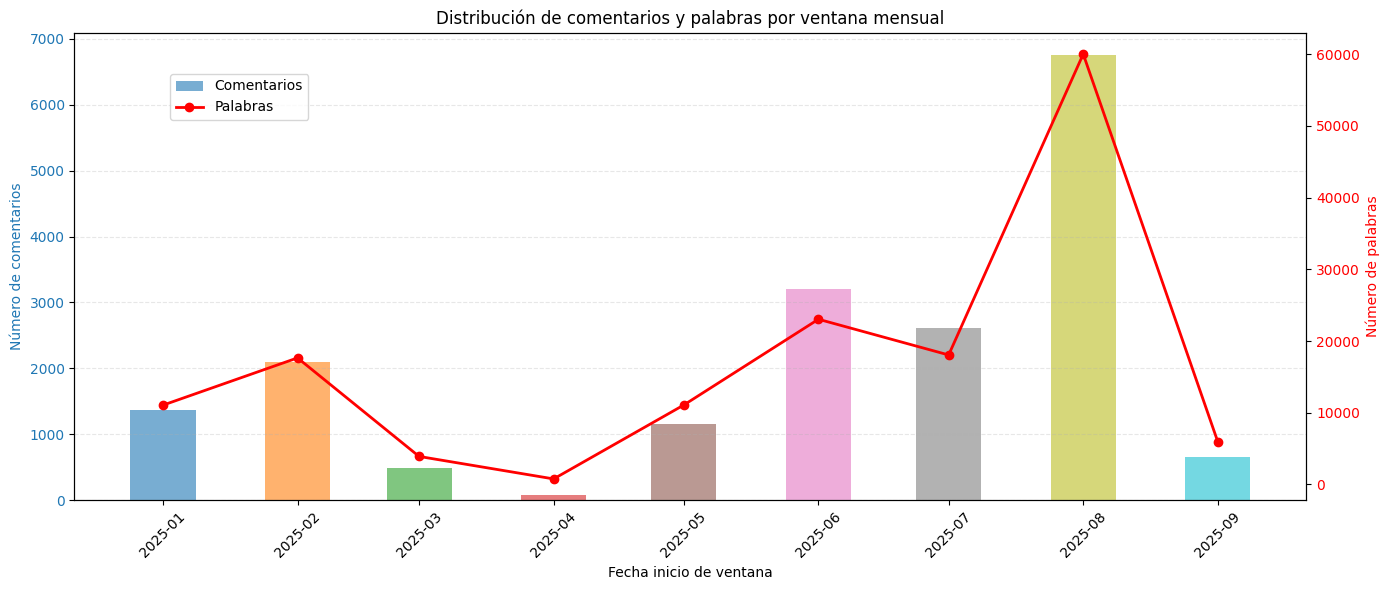

In [56]:
# Contar comentarios y palabras por ventana
monthly_comments = df['cleaned_comment'].resample('MS').size()
monthly_words = monthly_groups.apply(lambda x: len(x.split()))

# Crear colores para cada mes
months = sorted(monthly_comments.index.month.unique())
colors = cm.tab10(np.linspace(0, 1, len(months)))
color_dict = dict(zip(months, colors))

# Asignar color a cada barra mensual según el mes
bar_colors = [color_dict[d.month] for d in monthly_comments.index]

# Crear figura con doble eje Y
fig, ax1 = plt.subplots(figsize=(14,6))

# Eje Y izquierdo: Número de comentarios
ax1.bar(monthly_comments.index, monthly_comments.values, width=15, 
        color=bar_colors, alpha=0.6, label='Comentarios')
ax1.set_xlabel("Fecha inicio de ventana")
ax1.set_ylabel("Número de comentarios", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)

# Eje Y derecho: Número de palabras
ax2 = ax1.twinx()
ax2.plot(monthly_words.index, monthly_words.values, color='red', 
         marker='o', linewidth=2, label='Palabras')
ax2.set_ylabel("Número de palabras", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título y leyendas
plt.title("Distribución de comentarios y palabras por ventana mensual")
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
ax1.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

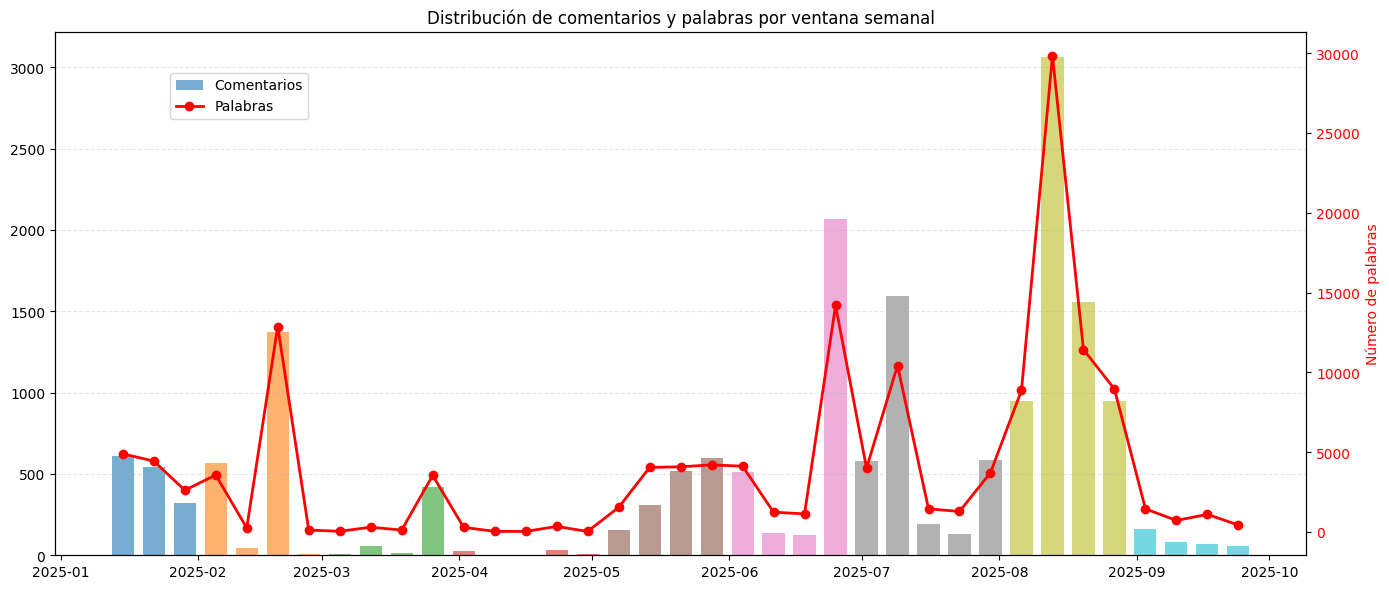

In [88]:
anchor = pd.Timestamp(df.index.min().year, 1, 1, tz=df.index.tz)

# 1) Comentarios por semana: mismos buckets de 7D anclados al 01-ene
weekly_comments = (
    df['cleaned_comment']
      .resample('7D', origin=anchor, label='left', closed='left')
      .size()
      .asfreq('7D')            # incluye semanas vacías (0)
)

# 2) Palabras por semana: reindexar para que comparta exactamente el mismo índice
weekly_words = (
    weekly_groups
      .reindex(weekly_comments.index, fill_value='')  # alinea semanas (vacías = '')
      .apply(lambda x: len(x.split()))
)

# 3) Colores por mes (mes del inicio de la semana)
months = pd.Index(weekly_comments.index.month)
uni_months = sorted(pd.unique(months))
colors = cm.tab10(np.linspace(0, 1, len(uni_months)))
color_dict = dict(zip(uni_months, colors))
bar_colors = [color_dict[m] for m in months]

# 4) Plot (ya alineados)
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.bar(weekly_comments.index, weekly_comments.values, width=5,
        color=bar_colors, alpha=0.6, label='Comentarios')
ax2 = ax1.twinx()
ax2.plot(weekly_words.index, weekly_words.values, color='red',
         marker='o', linewidth=2, label='Palabras')
ax2.set_ylabel("Número de palabras", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título y leyendas
plt.title("Distribución de comentarios y palabras por ventana semanal")
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
ax1.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')

def top_terms_by_window(groups, top_n=5, stopwords=None, window_name="ventana"):
    """
    Igual que tu función original, pero:
    - Ordena el índice temporal.
    - Soporta ventanas vacías: vectoriza solo donde hay texto y luego reindexa,
      preservando todas las ventanas (las vacías quedan en 0).
    - Maneja el caso de vocabulario reducido (top_n > n_terms).
    """
    # 0) Asegurar tipo str, NaN→'' y orden temporal
    docs = pd.Series(groups, copy=True)
    docs = docs.fillna('').astype(str)
    docs = docs.sort_index()

    original_index = docs.index

    # 1) Detectar ventanas con texto no vacío (tras strip)
    mask_nonempty = docs.str.strip().astype(bool)
    if mask_nonempty.sum() == 0:
        raise ValueError("No hay ventanas con texto no vacío para vectorizar.")

    docs_nonempty = docs[mask_nonempty]

    # 2) Conteo simple
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(docs_nonempty)
    terms = count_vectorizer.get_feature_names_out()

    if len(terms) == 0:
        raise ValueError("Vocabulario vacío (¿textos vacíos o solo stopwords?).")

    counts_df_nonempty = pd.DataFrame(
        count_matrix.toarray(),
        index=docs_nonempty.index,
        columns=terms
    )

    # 3) Selección de top terms por frecuencia global
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # 4) Reindexar a TODAS las ventanas (vacías → 0) para graficar continuo
    counts_df = (
        counts_df_nonempty
        .reindex(original_index, fill_value=0)
        .loc[:, top_terms]
    )

    # 5) Gráfico de frecuencias
    counts_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Frecuencia {window_name} de los {k} términos más frecuentes")
    plt.xlabel("Ventana de tiempo")
    plt.ylabel("Frecuencia")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) TF-IDF restringido al mismo vocabulario (top_terms)
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=docs_nonempty.index,
        columns=tfidf_vectorizer.get_feature_names_out()
    )

    tfidf_df = (
        tfidf_df_nonempty
        .reindex(original_index, fill_value=0.0)
        .loc[:, top_terms]
    )

    # 7) Gráfico de TF-IDF
    tfidf_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"TF-IDF {window_name} de los {k} términos más frecuentes")
    plt.xlabel("Ventana de tiempo")
    plt.ylabel("TF-IDF")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return counts_df, tfidf_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


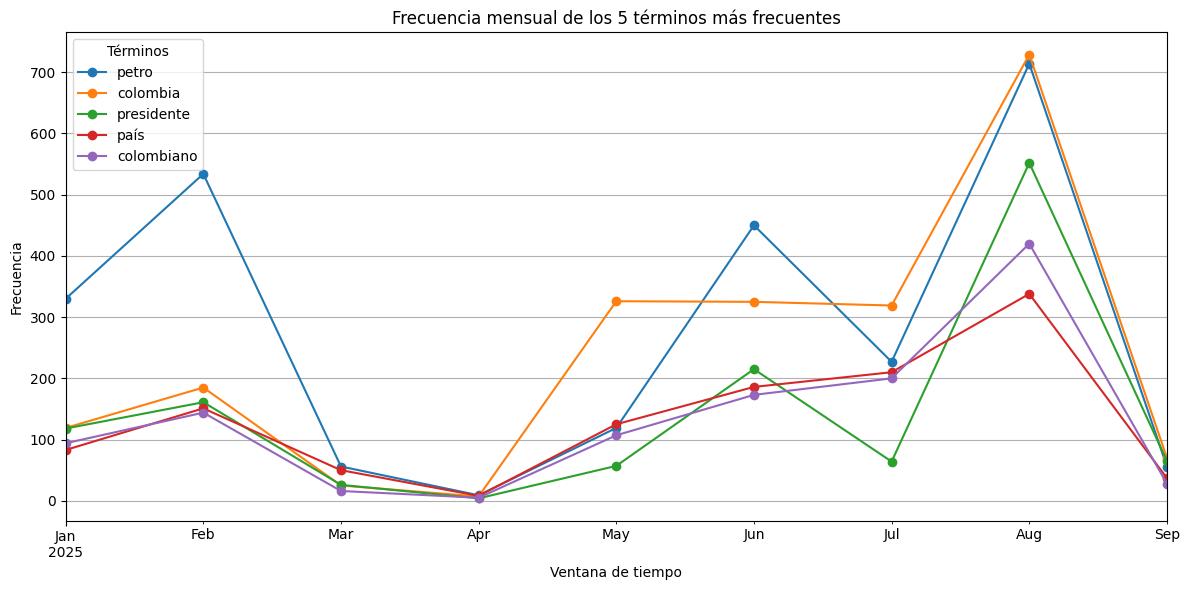

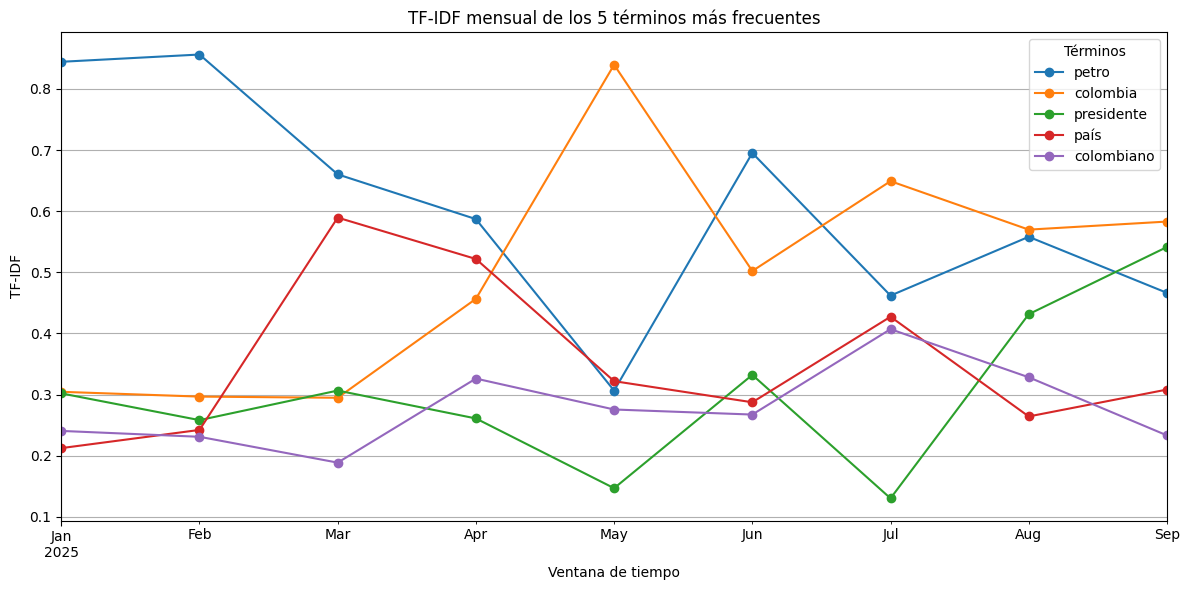

In [62]:
# Ventanas mensuales
counts_monthly, tfidf_monthly = top_terms_by_window(
    monthly_groups,
    top_n=5,
    stopwords=stopwords_es,
    window_name="mensual"
)

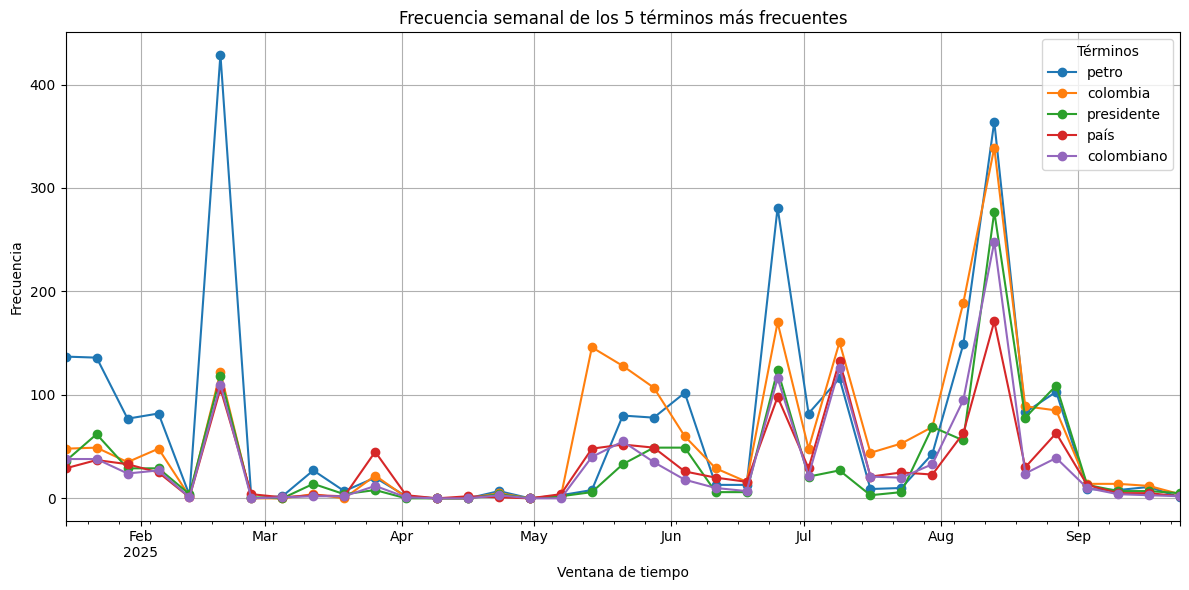

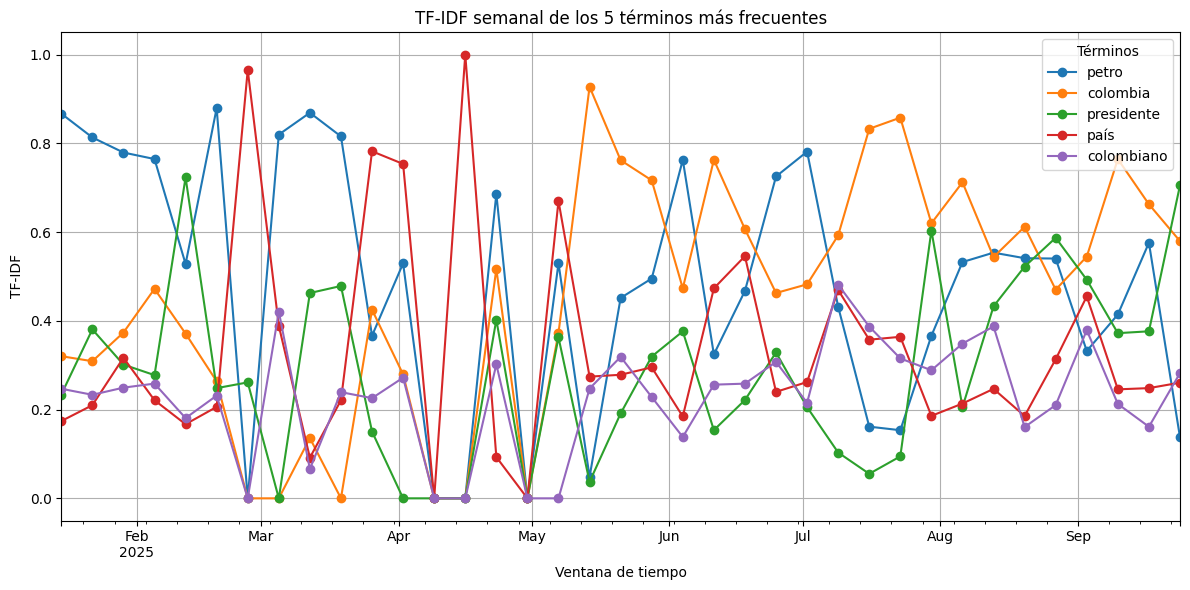

In [63]:
# Ventanas semanales
counts_weekly, tfidf_weekly = top_terms_by_window(
    weekly_groups,
    top_n=5,
    stopwords=stopwords_es,
    window_name="semanal"
)

In [71]:
def top_terms_by_days(
    df: pd.DataFrame,
    start_date,
    end_date,
    top_n: int = 5,
    stopwords=None,
    text_col: str = "cleaned_comment",
    datetime_col: str = "published_at",
):
    """
    Calcula frecuencias y TF-IDF de los top_n términos por DÍA
    en el rango [start_date, end_date] (incluyente). Incluye días sin datos.

    Retorna:
      counts_top (DataFrame): Frecuencia por día (una fila por día) de los top_n términos.
      tfidf_top  (DataFrame): TF-IDF por día de los mismos términos.
    """

    # --- 0) Asegurar índice datetime y orden
    if df.index.name != datetime_col:
        s = df.set_index(datetime_col)[text_col].copy()
    else:
        s = df[text_col].copy()

    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index().astype(str)

    if s.empty:
        raise ValueError("No hay datos con índice temporal válido.")

    idx_tz = s.index.tz

    # --- 1) Alinear fechas de entrada a la tz del índice (o naive si el índice lo es)
    def _align(ts):
        ts = pd.to_datetime(ts, errors="coerce")
        if pd.isna(ts):
            return None
        if idx_tz is None:
            return ts.tz_localize(None) if ts.tzinfo is not None else ts
        return ts.tz_localize(idx_tz) if ts.tzinfo is None else ts.tz_convert(idx_tz)

    start_ts = _align(start_date)
    end_ts   = _align(end_date)
    if start_ts is None or end_ts is None:
        raise ValueError("start_date o end_date no son fechas válidas.")
    if start_ts > end_ts:
        raise ValueError("start_date no puede ser mayor que end_date.")

    # Normalizar a medianoche para cubrir días completos
    start_day = start_ts.normalize()
    end_day   = end_ts.normalize()

    # --- 2) Recortar al rango de días (incluyente)
    # Usamos < end_day+1D para incluir todo el último día completo
    right_exclusive = end_day + pd.Timedelta(days=1)
    s_range = s[(s.index >= start_day) & (s.index < right_exclusive)]

    # Índice diario continuo (todas las fechas del rango, incluso vacías)
    daily_index = pd.date_range(start=start_day, end=end_day, freq="D", tz=idx_tz)

    # --- 3) Agregar por día (texto concatenado) y rellenar días vacíos
    daily_groups = (
        s_range.resample("D", origin=start_day, label="left", closed="left")
              .apply(lambda x: " ".join(x.astype(str)))
              .reindex(daily_index, fill_value="")
    )

    # --- 4) Vectorización robusta (evita vocabulario vacío)
    docs = daily_groups.fillna("").astype(str)
    mask = docs.str.strip().astype(bool)
    if mask.sum() == 0:
        raise ValueError("Todos los días del rango están vacíos (sin texto).")

    docs_nonempty = docs[mask]

    # Conteos
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(docs_nonempty)
    terms = count_vectorizer.get_feature_names_out()
    if len(terms) == 0:
        raise ValueError("Vocabulario vacío (¿todo son stopwords o textos vacíos?).")

    counts_df_nonempty = pd.DataFrame(
        count_matrix.toarray(),
        index=docs_nonempty.index,
        columns=terms
    )
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # Reinsertar días vacíos como 0 para eje continuo
    counts_df = (
        counts_df_nonempty
        .reindex(docs.index, fill_value=0)
        .loc[:, top_terms]
    )

    # --- 5) Gráfico de frecuencias por día
    counts_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Frecuencia diaria de los {k} términos más frecuentes ({start_day:%Y-%m-%d} → {end_day:%Y-%m-%d})")
    plt.xlabel("Día")
    plt.ylabel("Frecuencia")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # TF-IDF sobre el mismo vocabulario
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=docs_nonempty.index,
        columns=tfidf_vectorizer.get_feature_names_out()
    )
    tfidf_df = (
        tfidf_df_nonempty
        .reindex(docs.index, fill_value=0.0)
        .loc[:, top_terms]
    )

    # --- 6) Gráfico de TF-IDF por día
    tfidf_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"TF-IDF diario de los {k} términos más frecuentes ({start_day:%Y-%m-%d} → {end_day:%Y-%m-%d})")
    plt.xlabel("Día")
    plt.ylabel("TF-IDF")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return counts_df, tfidf_df

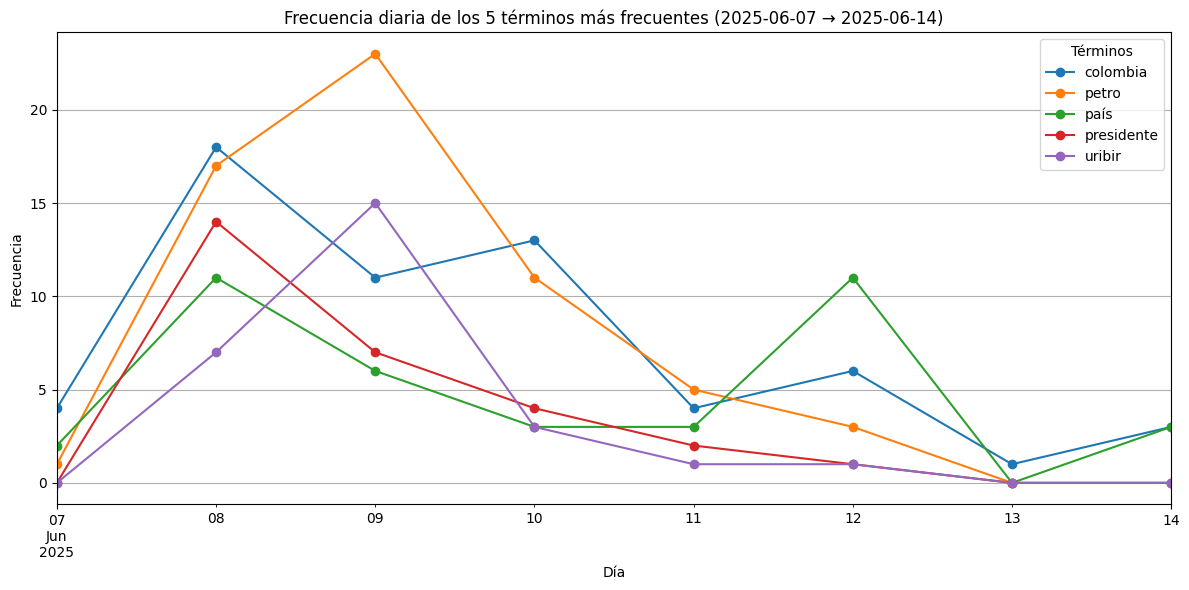

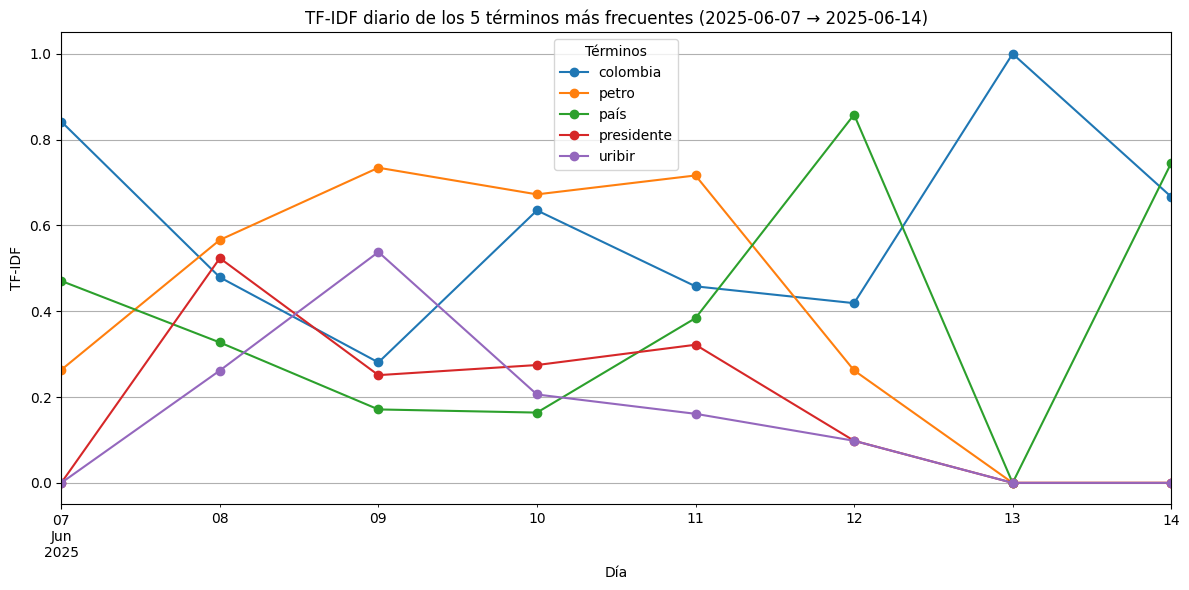

In [80]:
# Rango de fechas del atentado a Miguel Uribe
counts_daily, tfidf_daily = top_terms_by_days(
    df,
    start_date="2025-06-07",
    end_date="2025-06-14",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

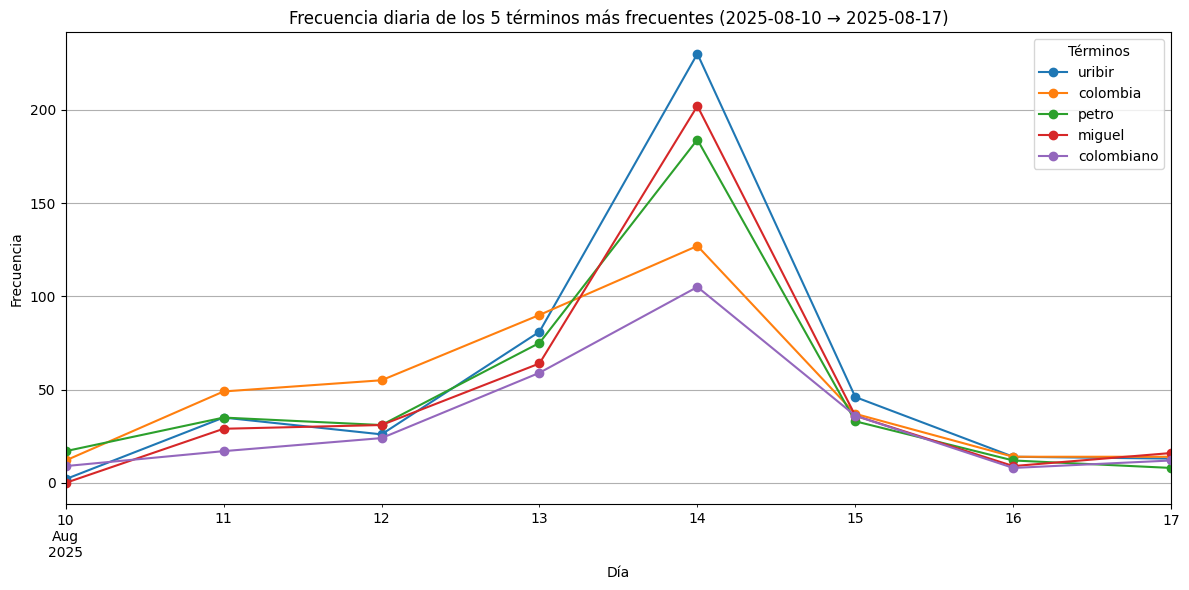

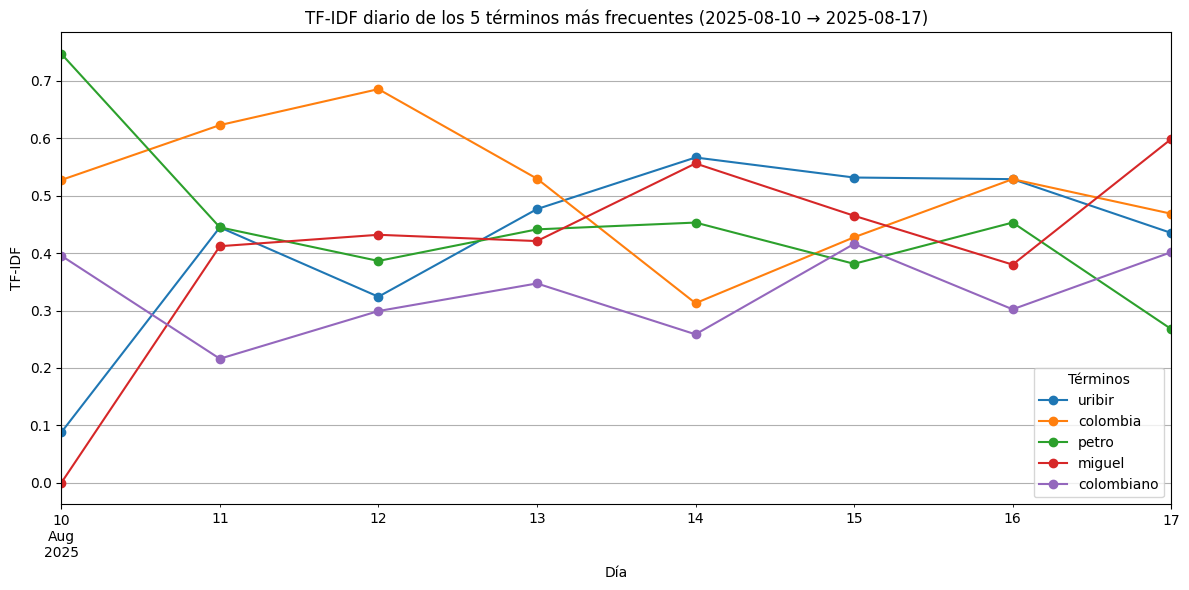

In [ ]:
# Rango de fechas del fallecimiento de Miguel Uribe a su funeral
counts_daily, tfidf_daily = top_terms_by_days(
    df,
    start_date="2025-08-10",
    end_date="2025-08-17",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

In [68]:
def top_terms_24h(
    df: pd.DataFrame,
    day,                              # "YYYY-MM-DD" o datetime-like
    top_n: int = 5,
    stopwords=None,
    text_col: str = "cleaned_comment",
    datetime_col: str = "published_at",
):
    """
    Calcula frecuencias y TF-IDF por HORA para un día dado (24 horas exactas).
    Incluye horas sin datos (se muestran como 0) para un eje continuo.

    Parámetros
    ----------
    df : DataFrame con columnas [datetime_col, text_col]
    day : str | datetime-like
        Día a analizar. Ej: "2025-08-11".
        La ventana será [day 00:00, day+1 00:00).
    top_n : int
        Número de términos a reportar.
    stopwords : list | None
        Stopwords a remover en la vectorización.
    text_col : str
        Nombre de la columna de texto.
    datetime_col : str
        Nombre de la columna datetime.

    Retorna
    -------
    counts_top : DataFrame
        Frecuencias por hora (24 filas) de los términos top_n.
    tfidf_top : DataFrame
        TF-IDF por hora (24 filas) de los términos top_n.
    """

    # --- 0) Asegurar índice datetime y tz coherente con el día
    if df.index.name != datetime_col:
        s = df.set_index(datetime_col)[text_col].copy()
    else:
        s = df[text_col].copy()

    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index().astype(str)

    if s.empty:
        raise ValueError("No hay datos con índice temporal válido.")

    # Tz del índice (None si es naive)
    idx_tz = s.index.tz

    # Normalizar "day" a la misma tz del índice
    day_ts = pd.to_datetime(day, errors="coerce")
    if pd.isna(day_ts):
        raise ValueError("El parámetro 'day' no es una fecha válida.")
    if idx_tz is None:
        # índice naive → asegurar day naive
        if day_ts.tzinfo is not None:
            day_ts = day_ts.tz_localize(None)
    else:
        # índice tz-aware → alinear day a esa tz
        if day_ts.tzinfo is None:
            day_ts = day_ts.tz_localize(idx_tz)
        else:
            day_ts = day_ts.tz_convert(idx_tz)

    start_ts = day_ts.normalize()                  # 00:00 de ese día (en la tz del índice)
    end_ts   = start_ts + pd.Timedelta(days=1)     # 24h semiabierto

    # --- 1) Recortar al día solicitado
    s_day = s.loc[start_ts:end_ts - pd.Timedelta(microseconds=1)]
    # Creamos el índice horario completo (24 marcas) para eje continuo
    hourly_index = pd.date_range(start=start_ts, end=end_ts, freq="H", tz=idx_tz, inclusive="left")

    # --- 2) Agregar por hora (texto concatenado) y rellenar horas vacías
    hourly_groups = (
        s_day.resample("H", origin=start_ts, label="left", closed="left")
            .apply(lambda x: " ".join(x.astype(str)))
            .reindex(hourly_index, fill_value="")
    )

    # --- 3) Vectorización robusta
    docs = hourly_groups.fillna("").astype(str)
    mask = docs.str.strip().astype(bool)
    if mask.sum() == 0:
        raise ValueError("Las 24 horas están vacías (no hay texto en ese día).")

    docs_nonempty = docs[mask]

    # Conteos
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(docs_nonempty)
    terms = count_vectorizer.get_feature_names_out()
    if len(terms) == 0:
        raise ValueError("Vocabulario vacío (¿todo son stopwords o textos vacíos?).")

    counts_df_nonempty = pd.DataFrame(
        count_matrix.toarray(),
        index=docs_nonempty.index,
        columns=terms
    )
    k = min(top_n, counts_df_nonempty.shape[1])
    top_terms = counts_df_nonempty.sum(axis=0).sort_values(ascending=False).head(k).index

    # Reinsertar horas vacías como 0 para eje continuo de 24 puntos
    counts_df = (
        counts_df_nonempty
        .reindex(docs.index, fill_value=0)
        .loc[:, top_terms]
    )

    # --- 4) Gráfico de frecuencias (24 horas)
    counts_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Frecuencia horaria de los {k} términos más frecuentes ({start_ts:%Y-%m-%d})")
    plt.xlabel("Hora")
    plt.ylabel("Frecuencia")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # TF-IDF sobre el mismo vocabulario
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, vocabulary=top_terms)
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs_nonempty)
    tfidf_df_nonempty = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=docs_nonempty.index,
        columns=tfidf_vectorizer.get_feature_names_out()
    )
    tfidf_df = (
        tfidf_df_nonempty
        .reindex(docs.index, fill_value=0.0)
        .loc[:, top_terms]
    )

    # --- 5) Gráfico TF-IDF (24 horas)
    tfidf_df.plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"TF-IDF horario de los {k} términos más frecuentes ({start_ts:%Y-%m-%d})")
    plt.xlabel("Hora")
    plt.ylabel("TF-IDF")
    plt.legend(title="Términos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return counts_df, tfidf_df

C:\Users\laura\AppData\Local\Temp\ipykernel_15756\2768192226.py:73: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_ts, end=end_ts, freq="H", tz=idx_tz, inclusive="left")
C:\Users\laura\AppData\Local\Temp\ipykernel_15756\2768192226.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s_day.resample("H", origin=start_ts, label="left", closed="left")


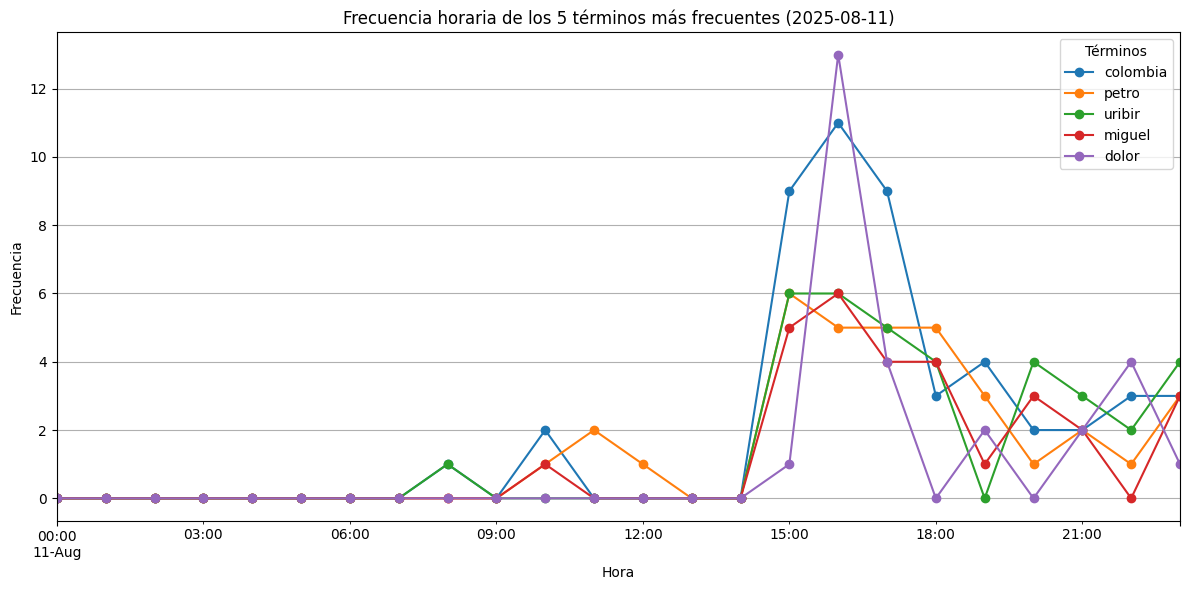

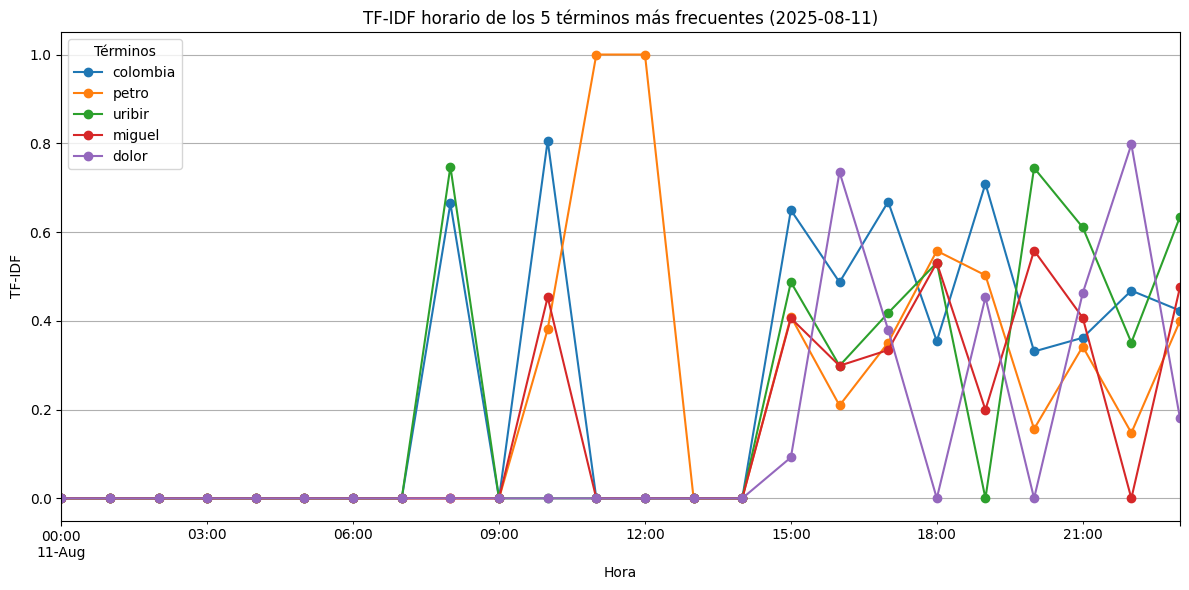

In [87]:
# Día del fallecimiento de Miguel Uribe
counts_24h, tfidf_24h = top_terms_24h(
    df,
    day="2025-08-11",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)

C:\Users\laura\AppData\Local\Temp\ipykernel_15756\2768192226.py:73: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_ts, end=end_ts, freq="H", tz=idx_tz, inclusive="left")
C:\Users\laura\AppData\Local\Temp\ipykernel_15756\2768192226.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s_day.resample("H", origin=start_ts, label="left", closed="left")


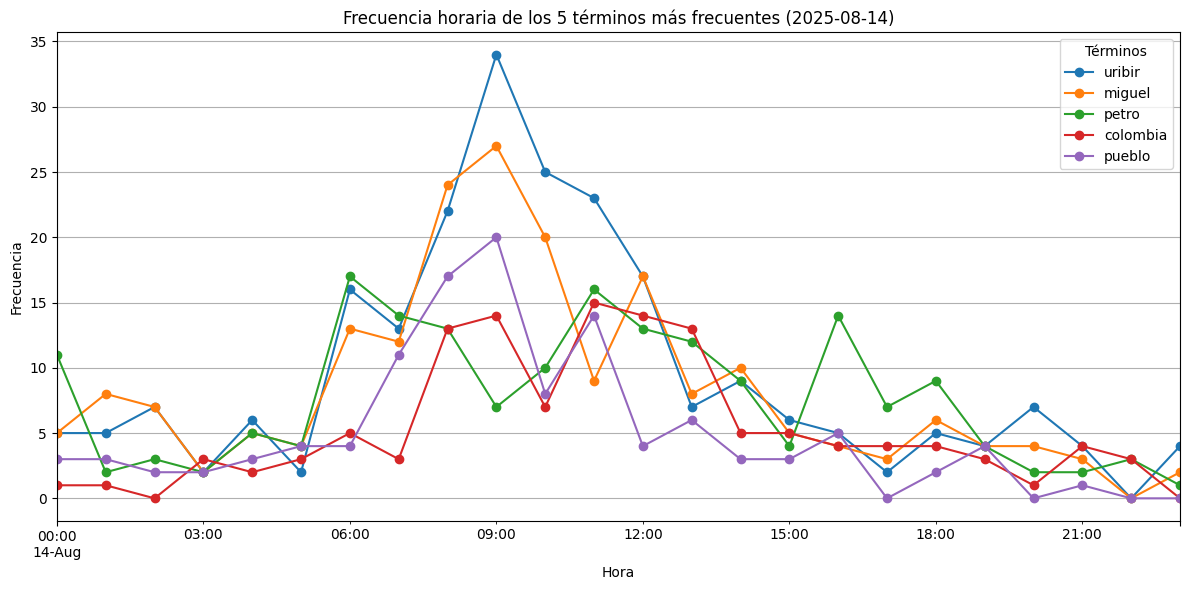

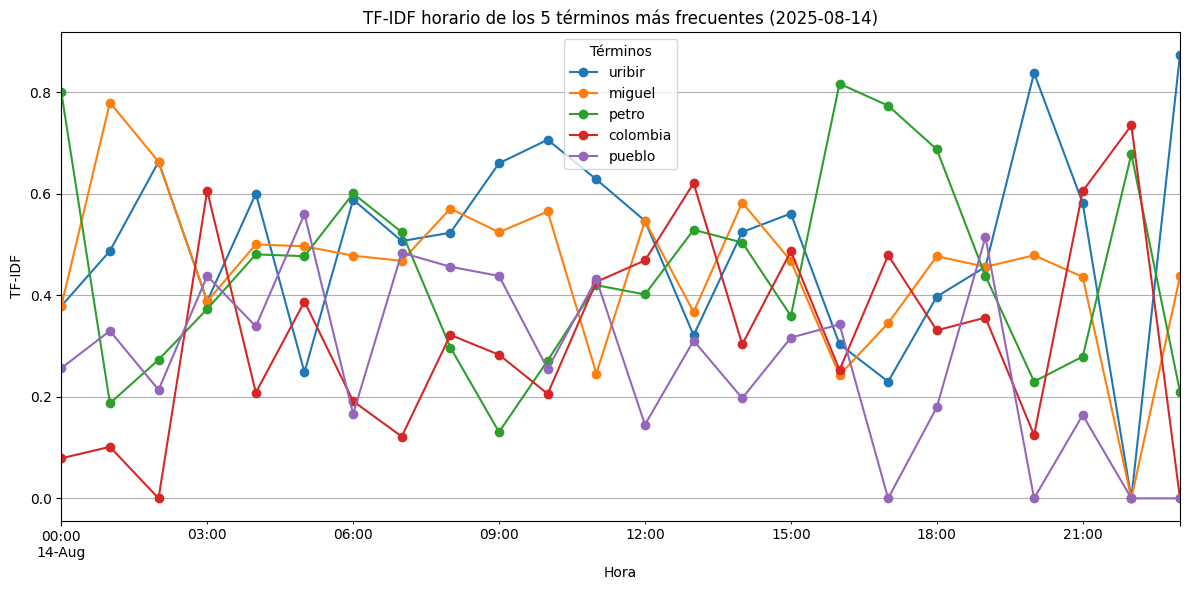

In [ ]:
# Día del funeral de Miguel Uribe
counts_24h, tfidf_24h = top_terms_24h(
    df,
    day="2025-08-14",
    top_n=5,
    stopwords=stopwords_es,
    text_col="cleaned_comment",
    datetime_col="published_at",
)